In [1]:
from typing import Callable, List, Tuple
from pathlib import Path
import os
import collections
from argparse import Namespace
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import albumentations as albu
import catalyst
from catalyst.dl import SupervisedRunner

# models
import segmentation_models_pytorch as smp
import catalyst.contrib.models.cv.segmentation as cataseg

# optimizer
from torch import optim
from catalyst.contrib.nn import RAdam, Lookahead

# losses
from catalyst.contrib.nn.criterion.lovasz import LovaszLossMultiClass
from catalyst.contrib.nn import DiceLoss, IoULoss

# metrics
from catalyst.dl import IouCallback, CriterionCallback, MetricAggregationCallback, DiceCallback, EarlyStoppingCallback
from catalyst.dl import SupervisedRunner 

# utilities
from pytorch_toolbelt.utils import count_parameters
from pytorch_toolbelt.losses import JointLoss
import utils as u

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

SEED = 42
catalyst.utils.set_global_seed(SEED)
catalyst.utils.prepare_cudnn(deterministic=True)

torch: 1.6.0, catalyst: 20.10.1


In [106]:
args = Namespace()
args.gpus = (0,)
args.num_workers = 4
args.is_fp16_used = False
args.batch_size = 7
args.num_epochs = 100
args.logdir = Path("./results/eni_salt/512to256_with_inversion50_normalized")
args.lr = 0.01
args.lr_enc = 0.005
args.lr_plateau_factor=0.25
args.lr_plateau_patience=2
args.opt_weight_decay=0.0003
args.enc_weight_decay=0.00003
args.num_classes = 1
args.patch_shape = (512, 512)
args.target_shape = (256, 256)
args.patch_stride = (512, 16)
args.use_horizons = False
args.use_depth = False
args.class_weights = tuple([1.]*args.num_classes)
args.loss_dice = 1.
args.loss_iou = 1.
args.loss_bce = .8
args.normalize = True
args.phase_inversion_training = .5

## Dataset

#### define transforms

In [107]:
def pre_transform(target_size):
    return [albu.Resize(target_size[0], target_size[1], p=1)]

def aug_transform():
    return [
        albu.HorizontalFlip(p=0.5),
        # albu.Downscale(scale_min=0.5, scale_max=0.95, p=0.1),
    ]  
  
def tensor_transforms(v2=False):
    # we convert it to torch.Tensor
    return [albu.pytorch.ToTensorV2()] if v2 else [albu.pytorch.ToTensor()]

def phase_transforms(p=.1):
    def _inv(x, **params):
        return -x
    return [albu.Lambda(image=_inv, name='inversion', p=p)]

def compose(transforms_list):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_list for item in sublist
    ])
    return result

#### define dataset class

In [108]:
class SegmentationDataset(Dataset):
    
    def __init__(self, images: np.ndarray, masks: np.ndarray = None, transforms=None) -> None:
        # arrays of patches
        
        self.images = images
        self.masks = masks

        self.transforms = transforms
    
    def __len__(self) -> int:
        return self.images.shape[0]
    
    def __getitem__(self, idx: int) -> dict:
                
        result = {"image": self.images[idx]}
        
        if self.masks is not None:
            # note: the squeeze() is necessary for the dimensions to be the same
            result['mask'] = self.masks[idx].squeeze()
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        return result

#### define loaders

In [109]:
def get_loaders(images: np.ndarray, masks: np.ndarray,
                random_state: int = 42, valid_size: float = 0.2, 
                batch_size: int = 32, num_workers: int = 4,
                split_shuffle: bool = False, epoch_shuffle: bool = True,
                train_transforms_fn = None, valid_transforms_fn = None) -> dict:
    
    indices = np.arange(images.shape[0])

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(indices,
                                                    test_size=valid_size,
                                                    random_state=random_state,
                                                    shuffle=split_shuffle)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
        images = images[train_indices],
        masks = masks[train_indices],
        transforms = train_transforms_fn
    )
    print('train dataset built')
    
    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
        images = images[valid_indices],
        masks = masks[valid_indices],
        transforms = valid_transforms_fn
    )
    print('validation dataset built')
    
    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=epoch_shuffle,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader
    print('loader created')
    return loaders

In [110]:
def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    
    plt.figure(figsize=(8,8))
    plt.imshow(image, cmap='gray', clim=u.plotting.clim(image, 95))
    plt.colorbar(aspect=50)
    plt.imshow(mask, cmap='jet', alpha=.1)
    plt.title(name)
    plt.tight_layout(pad=.5)
    plt.show()

#### Load numpy arrays

In [111]:
ROOT = Path("/nas/home/fpicetti/datasets/salt_eni")

train_image_path = ROOT / "image1.npy"
train_mask_path = ROOT / "label1.npy"
train_hor_path = ROOT / "edge1.npy"
train_depth_path = ROOT / "depth1.npy"

test_image_path = ROOT / "image2.npy"
test_depth_path = ROOT / "depth2.npy"
test_mask_path = ROOT / "label2.npy"

In [112]:
images_train = np.load(train_image_path)
if args.normalize:
    images_train = u.normalize_only(images_train)

depth_train = np.load(train_depth_path)

masks_train = np.load(train_mask_path)
hor_train = np.load(train_hor_path)

In [113]:
# cut the water in order to obtain 512 samples
z = images_train.shape[0] - 512

images_train = images_train[z:]
depth_train = depth_train[z:]
masks_train = masks_train[z:]
hor_train = hor_train[z:]

In [114]:
pe_y = u.PatchExtractor(args.patch_shape, stride=args.patch_stride)
print('total_patches: %d' % u.patch_extractor.count_patches(images_train.shape, pe_y.dim, pe_y.stride))
images_train.shape, u.patch_extractor.in_content_cropped_shape(images_train.shape, pe_y.dim, pe_y.stride)

total_patches: 158


((512, 3026), (512, 3024))

In [115]:
patches_images = pe_y.extract(images_train).reshape((-1,)+pe_y.dim+(1,))

In [116]:
patches_masks = pe_y.extract(masks_train).reshape((-1,)+pe_y.dim+(1,))

In [117]:
patches_hor = pe_y.extract(hor_train).reshape((-1,)+pe_y.dim+(1,))

In [118]:
patches_depths = pe_y.extract(depth_train).reshape((-1,)+pe_y.dim+(1,))

In [119]:
print(patches_images.shape)
print(patches_masks.shape)
print(patches_hor.shape)
print(patches_depths.shape)

(158, 512, 512, 1)
(158, 512, 512, 1)
(158, 512, 512, 1)
(158, 512, 512, 1)


In [120]:
def concat_ch(x, y):
    return np.concatenate((x,y), axis=-1)

In [121]:
patches_input = patches_images if not args.use_depth else concat_ch(patches_images, patches_depths)
patches_target = patches_masks if not args.use_horizons else concat_ch(patches_masks, patches_hor)

In [122]:
train_transforms = compose([
    pre_transform(args.target_shape),
    aug_transform(),
    phase_transforms(args.phase_inversion_training),
    tensor_transforms(False)])

valid_transforms = compose([
    pre_transform(args.target_shape),
    aug_transform(),
    phase_transforms(args.phase_inversion_training),
    tensor_transforms(False)])

show_transforms  = compose([aug_transform()])

In [123]:
batch_size = args.batch_size * (2 if args.is_fp16_used else 1)

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=patches_images,
    masks=patches_masks.astype(np.float32),
    random_state=SEED,
    valid_size=.1,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size,
    num_workers=args.num_workers,
    split_shuffle=True,
    epoch_shuffle=True,
)

batch_size: 7
train dataset built
validation dataset built
loader created


In [124]:
idx = 14
d = loaders['train'].dataset[idx]
x, y = d['image'], d['mask']
x.shape, y.shape


(torch.Size([1, 256, 256]), torch.Size([1, 256, 256]))

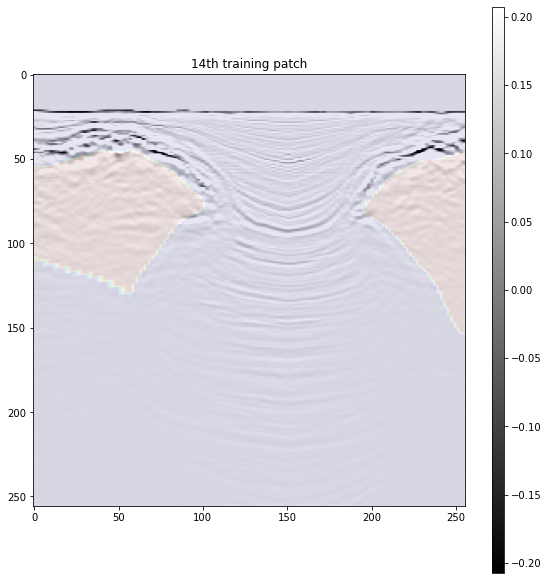

In [125]:
show_examples(f"{idx}th training patch", x.cpu().numpy().squeeze(), y.cpu().numpy().squeeze())

## Model

In [126]:
model = cataseg.FPNUnet(num_classes=args.num_classes,
                        in_channels=2 if args.use_depth else 1,
                        num_channels=16,
                        num_blocks=4)
# model = smp.FPN(encoder_name="resnext50_32x4d", classes=args.num_classes)

In [127]:
count_parameters(model)

{'total': 7801681,
 'trainable': 7801681,
 'encoder': 293712,
 'decoder': 128256,
 'head': 6493953}

#### Losses and metrics

In [128]:
# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}
callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": args.loss_dice, "loss_iou": args.loss_iou, "loss_bce": args.loss_bce},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

#### Optimizer and scheduling

In [129]:
# Since we use a pre-trained encoder, we will reduce the learning rate on it.
# This function removes weight_decay for biases and applies our layerwise_params
model_params = catalyst.utils.process_model_params(
    model, layerwise_params={"encoder*": dict(lr=args.lr_enc, weight_decay=args.enc_weight_decay)})

# Catalyst has new SOTA optimizers out of box
optimizer = Lookahead(RAdam(model_params, lr=args.lr, weight_decay=args.opt_weight_decay))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor=args.lr_plateau_factor,
                                                 patience=args.lr_plateau_patience)

In [130]:
y_true = y.unsqueeze(0)
y_pred = model(x.unsqueeze(0))

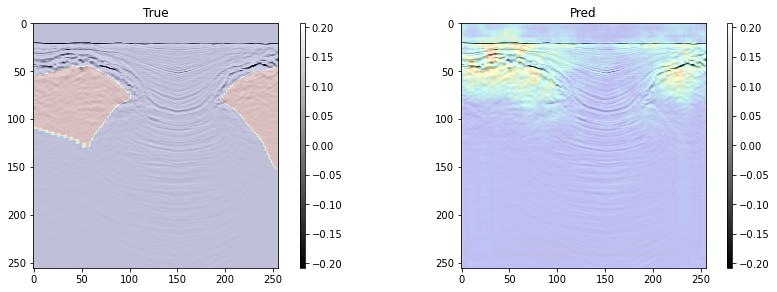

In [131]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.title('True')
plt.imshow(x.cpu().numpy().squeeze(), cmap='gray', clim=u.plotting.clim(x, 95)), plt.colorbar(aspect=50)
plt.imshow(y.cpu().numpy().squeeze(), cmap='jet', alpha=.2)
plt.subplot(122), plt.title('Pred')
plt.imshow(x.cpu().numpy().squeeze(), cmap='gray', clim=u.plotting.clim(x, 95)), plt.colorbar(aspect=50)
plt.imshow(y_pred.detach().numpy().squeeze(), cmap='jet', alpha=.2)
plt.tight_layout(pad=.5)
plt.show()

## Train

In [132]:
device = catalyst.utils.get_device()
print(f"device: {device}")

# params for FP16
fp16_params = dict(opt_level="O1") if args.is_fp16_used else None
print(f"FP16 params: {fp16_params}")

# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda
FP16 params: None


In [133]:
%load_ext tensorboard
%tensorboard --logdir {args.logdir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [134]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=args.logdir,
    num_epochs=args.num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

1/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.41it/s, dice=0.774, iou=0.631, loss=1.102, loss_bce=0.635, loss_dice=0.226, loss_iou=0.369]
1/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.90it/s, dice=0.002, iou=8.678e-04, loss=4.257, loss_bce=2.824, loss_dice=0.998, loss_iou=0.999]
[2020-11-04 22:06:49,655] 
1/100 * Epoch 1 (_base): lr=0.0050 | momentum=0.9000
1/100 * Epoch 1 (train): dice=0.6788 | iou=0.5292 | loss=1.1423 | loss_bce=0.4379 | loss_dice=0.3212 | loss_iou=0.4708
1/100 * Epoch 1 (valid): dice=0.0015 | iou=0.0008 | loss=4.2773 | loss_bce=2.8495 | loss_dice=0.9985 | loss_iou=0.9992
2/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.39it/s, dice=0.814, iou=0.687, loss=0.685, loss_bce=0.232, loss_dice=0.186, loss_iou=0.313]
2/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.90it/s, dice=0.133, iou=0.071, loss=2.998, loss_bce=1.503, loss_dice=0.867, loss_iou=0.929]
[2020-11-04 22:07:02,993] 
2/100 * Epoch 2 (_base): lr=0.0050 | momentum=0.9000
2/100 * Epoch 2 (train): dice=

15/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.30it/s, dice=0.954, iou=0.912, loss=0.181, loss_bce=0.059, loss_dice=0.046, loss_iou=0.088]
15/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.88it/s, dice=0.949, iou=0.903, loss=0.210, loss_bce=0.078, loss_dice=0.051, loss_iou=0.097]
[2020-11-04 22:09:54,157] 
15/100 * Epoch 15 (_base): lr=1.953e-05 | momentum=0.9000
15/100 * Epoch 15 (train): dice=0.9638 | iou=0.9302 | loss=0.1455 | loss_bce=0.0494 | loss_dice=0.0362 | loss_iou=0.0698
15/100 * Epoch 15 (valid): dice=0.9409 | iou=0.8885 | loss=0.2417 | loss_bce=0.0889 | loss_dice=0.0591 | loss_iou=0.1115
16/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.30it/s, dice=0.960, iou=0.924, loss=0.157, loss_bce=0.051, loss_dice=0.040, loss_iou=0.076]
16/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.86it/s, dice=0.952, iou=0.909, loss=0.195, loss_bce=0.071, loss_dice=0.048, loss_iou=0.091]
[2020-11-04 22:10:06,470] 
16/100 * Epoch 16 (_base): lr=4.883e-06 | momentum=0.9000
16/100 * Epoch 1

28/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.72it/s, dice=0.948, iou=0.901, loss=0.211, loss_bce=0.076, loss_dice=0.052, loss_iou=0.099]
[2020-11-04 22:12:38,246] 
28/100 * Epoch 28 (_base): lr=1.907e-08 | momentum=0.9000
28/100 * Epoch 28 (train): dice=0.9644 | iou=0.9313 | loss=0.1429 | loss_bce=0.0483 | loss_dice=0.0356 | loss_iou=0.0687
28/100 * Epoch 28 (valid): dice=0.9316 | iou=0.8724 | loss=0.2831 | loss_bce=0.1089 | loss_dice=0.0684 | loss_iou=0.1276
29/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.28it/s, dice=0.964, iou=0.931, loss=0.144, loss_bce=0.049, loss_dice=0.036, loss_iou=0.069]
29/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.82it/s, dice=0.952, iou=0.909, loss=0.198, loss_bce=0.073, loss_dice=0.048, loss_iou=0.091]
[2020-11-04 22:12:50,666] 
29/100 * Epoch 29 (_base): lr=1.907e-08 | momentum=0.9000
29/100 * Epoch 29 (train): dice=0.9637 | iou=0.9300 | loss=0.1452 | loss_bce=0.0487 | loss_dice=0.0363 | loss_iou=0.0700
29/100 * Epoch 29 (valid): dice=0.9420 

42/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.29it/s, dice=0.970, iou=0.941, loss=0.119, loss_bce=0.037, loss_dice=0.030, loss_iou=0.059]
42/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.79it/s, dice=0.952, iou=0.909, loss=0.194, loss_bce=0.070, loss_dice=0.048, loss_iou=0.091]
[2020-11-04 22:15:31,673] 
42/100 * Epoch 42 (_base): lr=4.768e-09 | momentum=0.9000
42/100 * Epoch 42 (train): dice=0.9655 | iou=0.9334 | loss=0.1382 | loss_bce=0.0464 | loss_dice=0.0345 | loss_iou=0.0666
42/100 * Epoch 42 (valid): dice=0.9442 | iou=0.8944 | loss=0.2267 | loss_bce=0.0816 | loss_dice=0.0558 | loss_iou=0.1056
43/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.29it/s, dice=0.965, iou=0.933, loss=0.143, loss_bce=0.052, loss_dice=0.035, loss_iou=0.067]
43/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.70it/s, dice=0.937, iou=0.882, loss=0.258, loss_bce=0.096, loss_dice=0.063, loss_iou=0.118]
[2020-11-04 22:15:44,044] 
43/100 * Epoch 43 (_base): lr=4.768e-09 | momentum=0.9000
43/100 * Epoch 4

55/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.89it/s, dice=0.948, iou=0.902, loss=0.212, loss_bce=0.078, loss_dice=0.052, loss_iou=0.098]
[2020-11-04 22:18:14,273] 
55/100 * Epoch 55 (_base): lr=4.768e-09 | momentum=0.9000
55/100 * Epoch 55 (train): dice=0.9647 | iou=0.9319 | loss=0.1416 | loss_bce=0.0477 | loss_dice=0.0353 | loss_iou=0.0681
55/100 * Epoch 55 (valid): dice=0.9444 | iou=0.8947 | loss=0.2279 | loss_bce=0.0839 | loss_dice=0.0556 | loss_iou=0.1053
56/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.30it/s, dice=0.961, iou=0.925, loss=0.163, loss_bce=0.062, loss_dice=0.039, loss_iou=0.075]
56/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.75it/s, dice=0.950, iou=0.905, loss=0.203, loss_bce=0.073, loss_dice=0.050, loss_iou=0.095]
[2020-11-04 22:18:26,617] 
56/100 * Epoch 56 (_base): lr=4.768e-09 | momentum=0.9000
56/100 * Epoch 56 (train): dice=0.9644 | iou=0.9314 | loss=0.1428 | loss_bce=0.0483 | loss_dice=0.0356 | loss_iou=0.0686
56/100 * Epoch 56 (valid): dice=0.9504 

69/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.30it/s, dice=0.941, iou=0.889, loss=0.233, loss_bce=0.078, loss_dice=0.059, loss_iou=0.111]
69/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.74it/s, dice=0.957, iou=0.917, loss=0.179, loss_bce=0.067, loss_dice=0.043, loss_iou=0.083]
[2020-11-04 22:21:07,582] 
69/100 * Epoch 69 (_base): lr=4.768e-09 | momentum=0.9000
69/100 * Epoch 69 (train): dice=0.9641 | iou=0.9308 | loss=0.1443 | loss_bce=0.0489 | loss_dice=0.0359 | loss_iou=0.0692
69/100 * Epoch 69 (valid): dice=0.9557 | iou=0.9152 | loss=0.1815 | loss_bce=0.0654 | loss_dice=0.0443 | loss_iou=0.0848
70/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.26it/s, dice=0.964, iou=0.931, loss=0.150, loss_bce=0.056, loss_dice=0.036, loss_iou=0.069]
70/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.84it/s, dice=0.958, iou=0.919, loss=0.172, loss_bce=0.061, loss_dice=0.042, loss_iou=0.081]
[2020-11-04 22:21:20,054] 
70/100 * Epoch 70 (_base): lr=4.768e-09 | momentum=0.9000
70/100 * Epoch 7

82/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.80it/s, dice=0.958, iou=0.920, loss=0.174, loss_bce=0.065, loss_dice=0.042, loss_iou=0.080]
[2020-11-04 22:24:00,644] 
82/100 * Epoch 82 (_base): lr=4.768e-09 | momentum=0.9000
82/100 * Epoch 82 (train): dice=0.9651 | iou=0.9326 | loss=0.1404 | loss_bce=0.0475 | loss_dice=0.0349 | loss_iou=0.0674
82/100 * Epoch 82 (valid): dice=0.9498 | iou=0.9045 | loss=0.2046 | loss_bce=0.0735 | loss_dice=0.0502 | loss_iou=0.0955
83/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.27it/s, dice=0.970, iou=0.943, loss=0.122, loss_bce=0.044, loss_dice=0.030, loss_iou=0.057]
83/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.80it/s, dice=0.953, iou=0.911, loss=0.194, loss_bce=0.073, loss_dice=0.047, loss_iou=0.089]
[2020-11-04 22:24:13,104] 
83/100 * Epoch 83 (_base): lr=4.768e-09 | momentum=0.9000
83/100 * Epoch 83 (train): dice=0.9639 | iou=0.9305 | loss=0.1451 | loss_bce=0.0493 | loss_dice=0.0361 | loss_iou=0.0695
83/100 * Epoch 83 (valid): dice=0.9503 

96/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.29it/s, dice=0.957, iou=0.918, loss=0.173, loss_bce=0.061, loss_dice=0.043, loss_iou=0.082]
96/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.82it/s, dice=0.954, iou=0.913, loss=0.185, loss_bce=0.066, loss_dice=0.046, loss_iou=0.087]
[2020-11-04 22:26:54,143] 
96/100 * Epoch 96 (_base): lr=4.768e-09 | momentum=0.9000
96/100 * Epoch 96 (train): dice=0.9643 | iou=0.9311 | loss=0.1434 | loss_bce=0.0485 | loss_dice=0.0357 | loss_iou=0.0689
96/100 * Epoch 96 (valid): dice=0.9446 | iou=0.8952 | loss=0.2249 | loss_bce=0.0808 | loss_dice=0.0554 | loss_iou=0.1048
97/100 * Epoch (train): 100% 20/20 [00:08<00:00,  2.27it/s, dice=0.955, iou=0.915, loss=0.187, loss_bce=0.071, loss_dice=0.045, loss_iou=0.085]
97/100 * Epoch (valid): 100% 2/2 [00:00<00:00,  3.82it/s, dice=0.956, iou=0.915, loss=0.179, loss_bce=0.062, loss_dice=0.044, loss_iou=0.085]
[2020-11-04 22:27:06,574] 
97/100 * Epoch 97 (_base): lr=4.768e-09 | momentum=0.9000
97/100 * Epoch 9

## Model inference

Let's look at the model's predictions.


In [135]:
images_test = np.load(test_image_path)
if args.normalize:
    images_test = u.normalize_only(images_test)

depths_test = np.load(test_depth_path)
masks_test  = np.load(test_mask_path)

z = images_test.shape[0] - 512

images_test = images_test[z:]
depths_test = depths_test[z:]
masks_test = masks_test[z:]

In [136]:
pe_test = u.PatchExtractor(args.patch_shape, stride=(128, 16))

In [137]:
patches_test_images = pe_test.extract(images_test).reshape((-1,)+pe_test.dim+(1,))
patches_test_depths = pe_test.extract(depths_test).reshape((-1,)+pe_test.dim+(1,))

In [138]:
test_transforms  = compose([pre_transform(args.target_shape), tensor_transforms(False)])
final_transforms = compose([pre_transform(pe_test.dim)])

In [139]:
patch_array_shape = u.patch_extractor.patch_array_shape(images_test.shape, pe_test.dim, pe_test.stride)

In [140]:
# create test dataset
test_dataset = SegmentationDataset(
    patches_test_images if not args.use_depth else concat_ch(patches_test_images, patches_test_depths), 
    transforms=test_transforms
)

infer_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
)

# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=infer_loader, resume=f"{args.logdir}/checkpoints/best.pth")
)))

print(predictions.shape)

(161, 1, 256, 256)


### build final image

In [141]:
result = []
for p in predictions:
    result.append(final_transforms(**{'image':p.transpose(1,2,0)})['image'])
result = np.asarray(result)
result.shape

(161, 512, 512, 1)

In [142]:
masks_pred = pe_test.reconstruct(result.reshape(patch_array_shape))

In [143]:
def binarize(x, th=0.5):
    x = u.normalize_only(x, zero_mean=False)
    x[x>=th] = 1
    x[x<th] = 0
    return x

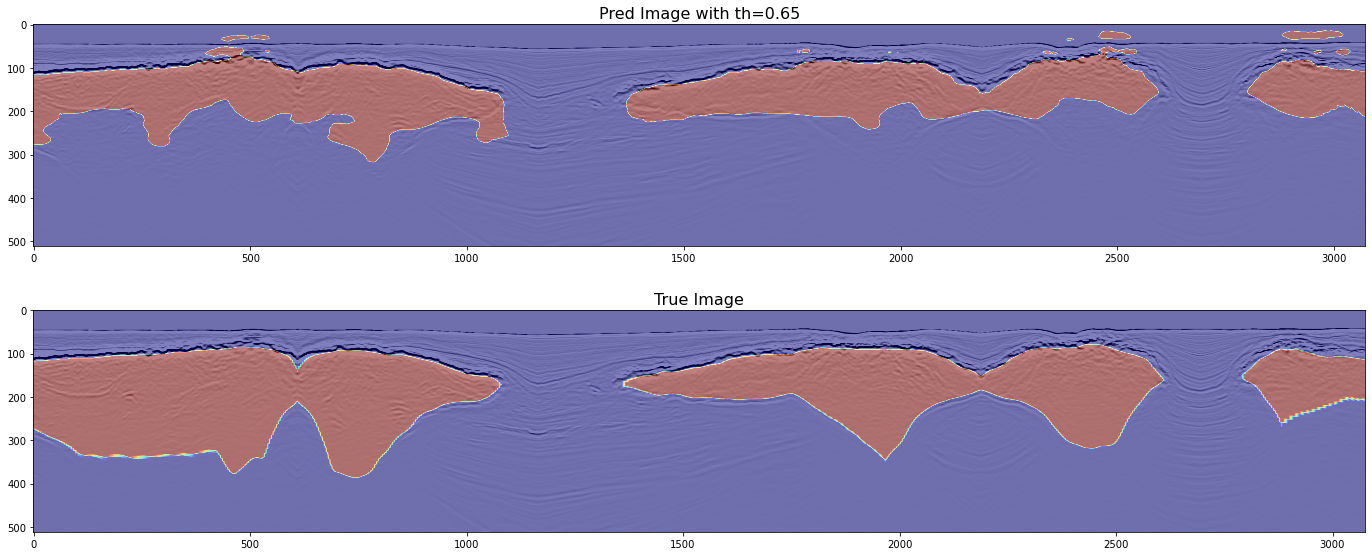

In [149]:
c = np.percentile(np.absolute(images_test), 95)
th = 0.65
plt.figure(figsize=(19,8))
plt.subplot(211), plt.title(f'Pred Image with th={th}', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(binarize(masks_pred, th), cmap='jet', alpha=0.5)

plt.subplot(212), plt.title('True Image', fontsize=16)
plt.imshow(images_test, cmap='gray', clim=(-c,c))
plt.imshow(masks_test, cmap='jet', alpha=0.5)

plt.tight_layout(pad=.5)
plt.show()

### Morphological post-processing

### Advanced: Custom Callbacks

Let's plot the heatmap of predicted masks.

In [25]:
import collections

from catalyst.dl import Callback, CallbackOrder, IRunner


class CustomInferCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.Internal)
        self.heatmap = None
        self.counter = 0

    def on_loader_start(self, runner: IRunner):
        self.predictions = None
        self.counter = 0

    def on_batch_end(self, runner: IRunner):
        # data from the Dataloader
        # image, mask = runner.input["image"], runner.input["mask"]
        logits = runner.output["logits"]
        probabilities = torch.sigmoid(logits)

        self.heatmap = (
            probabilities 
            if self.heatmap is None 
            else self.heatmap + probabilities
        )
        self.counter += len(probabilities)

    def on_loader_end(self, runner: IRunner):
        self.heatmap = self.heatmap.sum(axis=0)
        self.heatmap /= self.counter

In [26]:
from collections import OrderedDict
from catalyst.dl import CheckpointCallback


infer_loaders = {"infer": loaders["valid"]}
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)

device = utils.get_device()
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")
runner.infer(
    model=model,
    loaders=infer_loaders,
    callbacks=OrderedDict([
        ("loader", CheckpointCallback(resume=f"{logdir}/checkpoints/best.pth")),
        ("infer", CustomInferCallback())
    ]),
    fp16=fp16_params,
)

=> Loading checkpoint ./logs/segmentation/checkpoints/best.pth
loaded state checkpoint ./logs/segmentation/checkpoints/best.pth (global epoch 3, epoch 3, stage train)


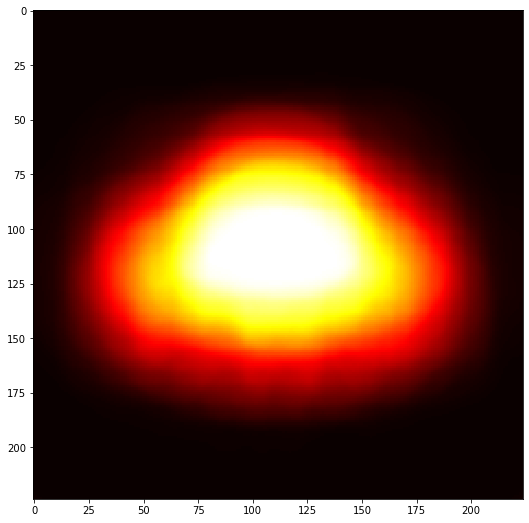

In [28]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt

heatmap = utils.detach(runner.callbacks["infer"].heatmap[0])
plt.figure(figsize=(20, 9))
plt.imshow(heatmap, cmap="hot", interpolation="nearest")
plt.show()

### Advanced: test-time augmentations (TTA)

There is [ttach](https://github.com/qubvel/ttach) is a new awesome library for test-time augmentation for segmentation or classification tasks.

In [30]:
!pip install ttach

In [31]:
import ttach as tta

# D4 makes horizontal and vertical flips + rotations for [0, 90, 180, 270] angels.
# and then merges the result masks with merge_mode="mean"
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode="mean")

tta_runner = SupervisedRunner(
    model=tta_model,
    device=utils.get_device(),
    input_key="image"
)

In [32]:
infer_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

batch = next(iter(infer_loader))

# predict_batch will automatically move the batch to the Runner's device
tta_predictions = tta_runner.predict_batch(batch)

# shape is `batch_size x channels x height x width`
print(tta_predictions["logits"].shape)

torch.Size([1, 1, 224, 224])


Let's see our mask after TTA

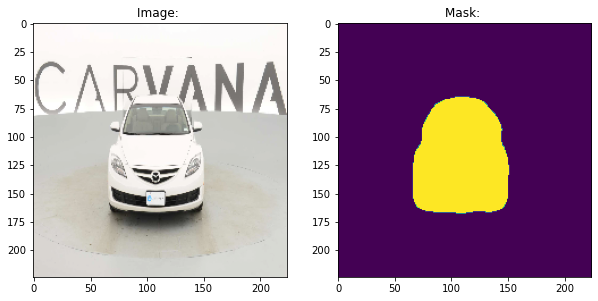

In [33]:
threshold = 0.5

image = utils.tensor_to_ndimage(batch["image"][0])

mask_ = tta_predictions["logits"][0, 0].sigmoid()
mask = utils.detach(mask_ > threshold).astype("float")

show_examples(name="", image=image, mask=mask)